## Import Libraries

In [1]:
# Dataset Processing
from PIL import Image
import numpy as np
import pandas as pd
import cv2

# Machine Learning
from sklearn.model_selection import train_test_split

import tensorflow as tf
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, BatchNormalization

# Plotting
import matplotlib.pyplot as plt
import seaborn as sns
import os

%matplotlib inline

## Define Constants

In [2]:
IMAGE_WIDTH=28
IMAGE_HEIGHT=28
IMAGE_SIZE=(IMAGE_WIDTH, IMAGE_HEIGHT)
IMAGE_CHANNELS=1

ROOT_DIR = os.path.abspath("./")
LABEL2INT ={"A": 0, "B": 1, "C": 2, "D": 3,
            "E": 4, "F": 5, "G": 6, "H": 7,
            "I": 8, "K": 9, "L": 10, "M": 11,
            "N": 12, "O": 13, "P": 14, "Q": 15,
            "R": 16, "S": 17, "T": 18, "U": 19,
            "V": 20, "W": 21, "X": 22, "Y": 23}
# LABEL2INT ={"A": 0, "B": 1, "C": 2, "D": 3,
#             "E": 4, "F": 5, "G": 6, "H": 7,
#             "I": 8, "J": 9, "K": 10, "L": 11,
#             "M": 12, "N": 13, "O": 14, "P": 15,
#             "Q": 16, "R": 17, "S": 18, "T": 19,
#             "U": 20, "V": 21, "W": 22, "X": 23,
#             "Y": 24, "Z": 25}

## Load Dataset
### 2.1 Extract filenames

In [10]:
filenames = os.listdir(f"{ROOT_DIR}/SLC_MNIST_DATA")

# filename format: [category].[id].jpg

categories = []
for filename in filenames:
    category = filename.split('.')[0]
    categories.append(LABEL2INT[category])

df = pd.DataFrame({
    'filename': filenames,
    'category': categories
})

In [6]:
df['filename']

0      A.0.png
1      B.1.png
2      C.2.png
3      D.3.png
4      E.4.png
5      F.5.png
6      G.6.png
7      H.7.png
8      I.8.png
9     K.10.png
10    L.11.png
11    M.12.png
12    N.13.png
13    O.14.png
14    P.15.png
15    Q.16.png
16    R.17.png
17    S.18.png
18    T.19.png
19    U.20.png
20    V.21.png
21    W.22.png
22    X.23.png
23    Y.24.png
Name: filename, dtype: object

In [4]:
df['category']

0      0
1      1
2      2
3      3
4      4
5      5
6      6
7      7
8      8
9      9
10    10
11    11
12    12
13    13
14    14
15    15
16    16
17    17
18    18
19    19
20    20
21    21
22    22
23    23
Name: category, dtype: int64

### 2.2 Convert filenames to images

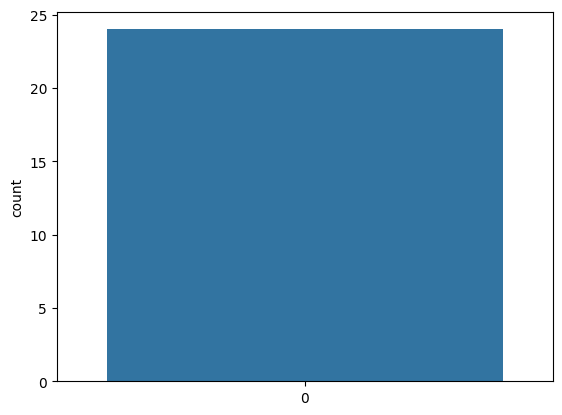

In [59]:
def filename_to_image(filename):
    img = Image.open(f"{ROOT_DIR}/SLC_MNIST_DATA/{filename}")
    img = img.resize(IMAGE_SIZE)
    return np.array(img).astype('float32')

train_df, test_df = train_test_split(df, test_size=0.20, random_state=42)

X_train = train_df['filename'].apply(filename_to_image)
Y_train = train_df['category']

X_test = test_df['filename'].apply(filename_to_image)
Y_test = test_df['category']

g = sns.countplot(df['category'])

### 2.3 Label encoding

In [60]:
tensor = tf.convert_to_tensor(X_train)

ValueError: Failed to convert a NumPy array to a Tensor (Unsupported object type numpy.ndarray).

In [57]:
X_train 

9     [[114, 122, 127, 130, 133, 137, 142, 144, 146,...
13    [[167, 169, 170, 171, 171, 172, 172, 172, 171,...
1     [[181, 182, 183, 182, 183, 183, 183, 183, 182,...
21    [[159, 162, 167, 169, 172, 175, 176, 177, 179,...
5     [[174, 177, 179, 181, 183, 184, 185, 188, 193,...
2     [[164, 166, 167, 167, 168, 168, 168, 168, 168,...
12    [[189, 189, 190, 190, 192, 193, 193, 193, 193,...
15    [[153, 158, 161, 162, 165, 170, 174, 177, 179,...
3     [[163, 165, 166, 167, 167, 167, 168, 168, 169,...
4     [[178, 178, 179, 179, 178, 178, 177, 176, 177,...
22    [[179, 180, 180, 180, 182, 181, 182, 183, 182,...
17    [[174, 174, 174, 174, 174, 175, 175, 174, 173,...
20    [[190, 191, 194, 198, 198, 198, 198, 199, 200,...
23    [[174, 177, 179, 180, 180, 183, 183, 183, 183,...
7     [[222, 223, 220, 220, 221, 221, 222, 222, 222,...
10    [[170, 172, 175, 177, 179, 182, 185, 186, 187,...
14    [[81, 88, 95, 106, 120, 118, 123, 132, 136, 13...
19    [[162, 168, 172, 176, 179, 183, 184, 185, 

In [55]:
X_train = tf.convert_to_tensor(X_train.to_numpy().astype(np.float32))
X_test = tf.convert_to_tensor(X_test.to_numpy().astype(np.float32))

ValueError: setting an array element with a sequence.

In [78]:
# Encode labels to one hot vectors (ex : "B" -> 0 -> [0,1,0,0,0,0,
                                                    # 0,0,0,0,0,0,
                                                    # 0,0,0,0,0,0,
                                                    # 0,0,0,0,0,0,
                                                    # 0,0])
Y_train = to_categorical(Y_train, num_classes=24, dtype='int32')
Y_test = to_categorical(Y_test, num_classes=24, dtype="int32")

### 2.4 Example Sample

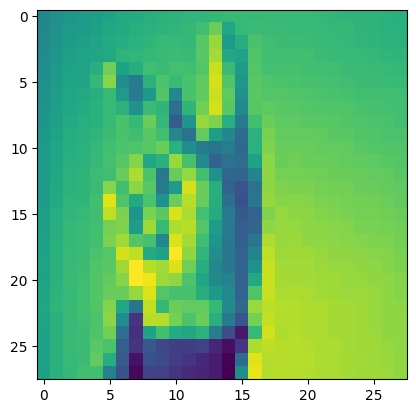

In [47]:
# Some examples
g = plt.imshow(X_train[0][:,:])

## CNN
### 3.1 Define the model

In [48]:
# Set the CNN model 
# our CNN architechture is In -> [[Conv2D->relu] -> BatchNormalize -> MaxPool2D]*3 -> Flatten -> Dense -> BatchNormalize -> Out

model = Sequential()

model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_CHANNELS)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(BatchNormalization())
model.add(Dense(25, activation='softmax'))

### 3.2 Set the Optimizer

In [49]:
# Compile the model
model.compile(optimizer = 'rmsprop', loss = "categorical_crossentropy", metrics=["accuracy"])

## Training

In [81]:
X_train.shape, Y_train.shape, X_test.shape, Y_test.shape

((19,), (19, 25), (5,), (5, 25))

In [50]:
model.fit(X_train, Y_train, batch_size = 4, epochs = 10, validation_data = (X_test, Y_test))

ValueError: Failed to convert a NumPy array to a Tensor (Unsupported object type numpy.ndarray).

## Evaluation

# Advanced Concepts
## Preprocessing 
Histogram Equalization, Mean Normalization, Standard Deviation Normalization
## Augmentation
Rotating, Mirroring, Blurring, Noising
## Regularization
Handling Overfitting
## Model Designing
## Optimizers
## Finetuning Existing Models